In [1]:
#hide
if IN_COLAB:
    !pip install -Uqq fastbook

NameError: name 'IN_COLAB' is not defined

In [1]:
import fastbook
fastbook.setup_book()

In [2]:
#hide
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

In [4]:
path = untar_data(URLs.MNIST)

In [5]:
path

Path('/Users/rnm/.fastai/data/mnist_png')

In [6]:
!ls {path}/'training'/'3'|wc -l

    6131


In [7]:
Path.BASE_PATH = path

In [8]:
path.ls()

(#3) [Path('.DS_Store'),Path('training'),Path('testing')]

In [9]:
DIGITS = range(0,10)
train_digit_paths = [(path/'training'/str(digit)).ls().sorted()
                        for digit in DIGITS]

In [10]:
train_digit_paths[3]

(#6131) [Path('training/3/10.png'),Path('training/3/10000.png'),Path('training/3/10011.png'),Path('training/3/10031.png'),Path('training/3/10034.png'),Path('training/3/10042.png'),Path('training/3/10052.png'),Path('training/3/1007.png'),Path('training/3/10074.png'),Path('training/3/10091.png')...]

In [11]:
Image.open(train_digit_paths[3][-1])

In [12]:
# train_t == stacked train tensors
# train_t = torch.stack(tensor(Image.open(train_digit_paths)))
# train_t = torch.stack(tensor(Image.open(img))
#                      for img in train_digit_paths[d]
#                          for d in digits).float()/255

# train_t = []
# for d in DIGITS:
#     train_t[d] = torch.stack(tensor(Image.open(img))
#                      for img in train_digit_paths[d]).float()/255

# did not work - need 2 steps (1) get tensors (2) stack
# train_digit_tensors = L([])
# for d in DIGITS:
#     train_digit_tensors[d] = [tensor(Image.open(img)) for img in train_digit_paths[d]]
# IndexError: list assignment index out of range

# Cannot index into list if element does not exist
# Since list is being created now, use .append()

In [15]:
train_digit_tensors_3 = [tensor(Image.open(img))
                          for img in train_digit_paths[3]]
len(train_digit_tensors_3), train_digit_tensors_3[0].shape
# am able to read all of a specific digit into list

(6131, torch.Size([28, 28]))

In [18]:
train_digit_tensors = [[tensor(Image.open(img))
                          for img in train_digit_paths[d]]
                          for d in DIGITS]
# am able to read all images of all digits into list of lists

In [19]:
len(train_digit_tensors), len(train_digit_tensors[3])

(10, 6131)

In [20]:
train_digit_tensors = torch.stack(
    [torch.stack(
        [tensor(Image.open(img))
            for img in train_digit_paths[d]])
                for d in DIGITS])
# RuntimeError: stack expects each tensor to be equal size, but got [5923, 28, 28] at entry 0 and [6742, 28, 28] at entry 1
# unable to stack if jagged i.e. # of images not same for all digits

RuntimeError: stack expects each tensor to be equal size, but got [5923, 28, 28] at entry 0 and [6742, 28, 28] at entry 1

In [21]:
train_digit_tensors = [torch.stack(
    [tensor(Image.open(img)).float()/255
        for img in train_digit_paths[d]])
            for d in DIGITS]
# am able to create list of 10 stacked tensors

In [22]:
for d in DIGITS:
    print(d, train_digit_tensors[d].shape)

0 torch.Size([5923, 28, 28])
1 torch.Size([6742, 28, 28])
2 torch.Size([5958, 28, 28])
3 torch.Size([6131, 28, 28])
4 torch.Size([5842, 28, 28])
5 torch.Size([5421, 28, 28])
6 torch.Size([5918, 28, 28])
7 torch.Size([6265, 28, 28])
8 torch.Size([5851, 28, 28])
9 torch.Size([5949, 28, 28])


In [23]:
# now, create baseline prediction
# 1. compute 'average' digit
# 2. figure out loss / error for each sample from each 'average' digit
# 3. assume prediction is digit matching least distance
# 4. find out sum of loss for entire training set
# 5. assume metric is accuracy
# 6. compute metric by applying model on validation dataset

train_digit_means = [train_digit_tensors[d].mean((-1, -2)) for d in DIGITS]

In [26]:
len(train_digit_means)

10

In [28]:
type(train_digit_means[2]), train_digit_means[2].shape
# incorrect - expect shape to be [28, 28]

(torch.Tensor, torch.Size([5958]))

In [29]:
train_digit_means = [train_digit_tensors[d].mean((0)) for d in DIGITS]
type(train_digit_means[2]), train_digit_means[2].shape
# this worked - don't know why mean((0)) is not same as mean((-1, -2))

(torch.Tensor, torch.Size([28, 28]))

[<AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>]

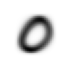

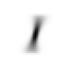

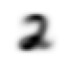

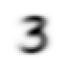

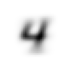

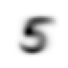

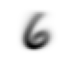

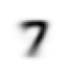

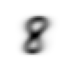

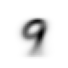

In [30]:
[show_image(train_digit_means[d]) for d in DIGITS]
# expect least accuracy in 4 and 9

(<AxesSubplot:>, <AxesSubplot:>)

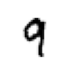

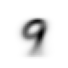

In [31]:
one_9 = train_digit_tensors[9][5000]
show_image(one_9), show_image(train_digit_means[9])

In [32]:
# F is torch.Functional
# MAD == L1, MSE == L2
print(F.l1_loss(one_9, train_digit_means[9]),
(one_9 - train_digit_means[9]).abs().mean(),
F.mse_loss(one_9, train_digit_means[9]).sqrt(),
((one_9 - train_digit_means[9])**2).mean().sqrt())
# for single sample, get distance from average 9 in two different ways

tensor(0.0967) tensor(0.0967) tensor(0.1855) tensor(0.1855)


In [33]:
for d in DIGITS:
    print(F.l1_loss(one_9, train_digit_means[d]), F.mse_loss(one_9, train_digit_means[d]).sqrt())
    # for single sample, get distance from all 10 master images

tensor(0.1868) tensor(0.3180)
tensor(0.1252) tensor(0.2821)
tensor(0.1584) tensor(0.2723)
tensor(0.1462) tensor(0.2632)
tensor(0.1151) tensor(0.2183)
tensor(0.1402) tensor(0.2503)
tensor(0.1433) tensor(0.2672)
tensor(0.1216) tensor(0.2400)
tensor(0.1370) tensor(0.2457)
tensor(0.0967) tensor(0.1855)


In [34]:
# for each sample in validation:
# compare against 10 master images
# find lowest loss
# if matches label, correct prediction

In [35]:
valid_digit_paths = [(path/'testing'/str(digit)).ls().sorted()
                        for digit in DIGITS]
valid_digit_tensors = [torch.stack(
    [tensor(Image.open(img)).float()/255
        for img in valid_digit_paths[d]])
            for d in DIGITS]
for d in DIGITS:
    print(d, valid_digit_tensors[d].shape)
# nothing more can be done here to vectorize or use tensors

0 torch.Size([980, 28, 28])
1 torch.Size([1135, 28, 28])
2 torch.Size([1032, 28, 28])
3 torch.Size([1010, 28, 28])
4 torch.Size([982, 28, 28])
5 torch.Size([892, 28, 28])
6 torch.Size([958, 28, 28])
7 torch.Size([1028, 28, 28])
8 torch.Size([974, 28, 28])
9 torch.Size([1009, 28, 28])


(<AxesSubplot:>, <AxesSubplot:>)

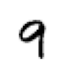

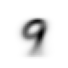

In [36]:
one_9 = valid_digit_tensors[9][100]
show_image(one_9), show_image(train_digit_means[9])

In [39]:
loss_tensor = L([])

for d in DIGITS:
    loss_tensor.append(F.l1_loss(one_9, train_digit_means[d]))
    print(F.l1_loss(one_9, train_digit_means[d]), F.mse_loss(one_9, train_digit_means[d]).sqrt())
val, idx = min((val, idx) for (idx, val) in enumerate(loss_tensor))
print(f'Lowest loss: {val}, {idx}')

tensor(0.1950) tensor(0.3318)
tensor(0.1413) tensor(0.3026)
tensor(0.1647) tensor(0.2858)
tensor(0.1658) tensor(0.2950)
tensor(0.1218) tensor(0.2314)
tensor(0.1591) tensor(0.2816)
tensor(0.1535) tensor(0.2843)
tensor(0.1317) tensor(0.2582)
tensor(0.1487) tensor(0.2676)
tensor(0.1096) tensor(0.2135)
Lowest loss: 0.10960502922534943, 9


/Users/rnm/miniconda3/lib/python3.8/site-packages/fastai/torch_core.py:60: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if ax is None: _,ax = plt.subplots(figsize=figsize)


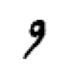

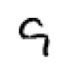

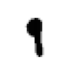

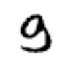

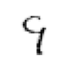

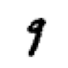

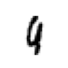

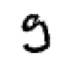

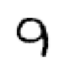

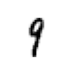

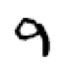

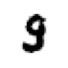

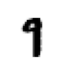

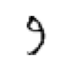

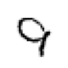

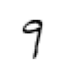

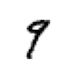

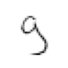

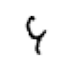

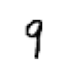

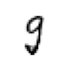

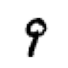

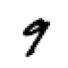

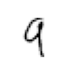

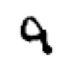

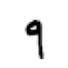

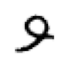

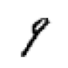

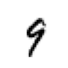

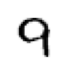

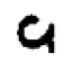

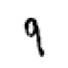

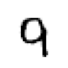

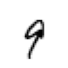

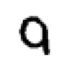

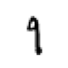

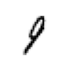

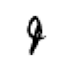

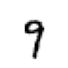

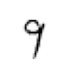

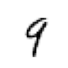

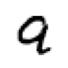

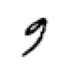

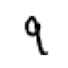

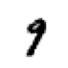

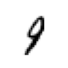

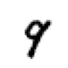

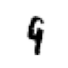

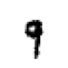

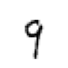

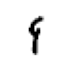

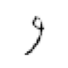

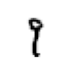

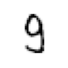

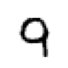

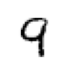

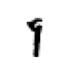

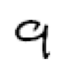

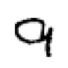

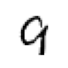

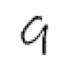

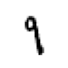

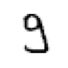

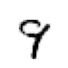

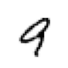

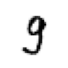

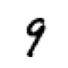

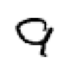

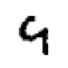

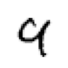

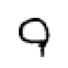

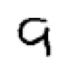

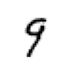

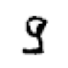

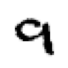

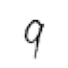

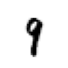

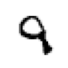

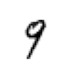

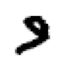

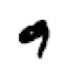

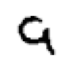

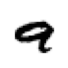

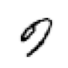

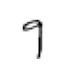

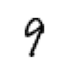

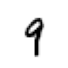

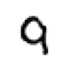

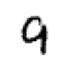

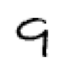

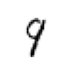

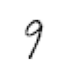

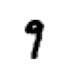

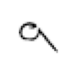

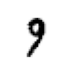

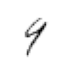

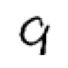

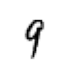

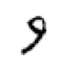

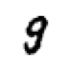

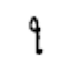

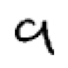

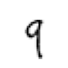

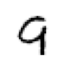

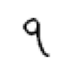

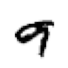

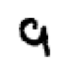

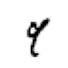

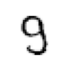

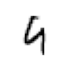

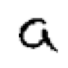

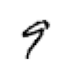

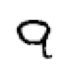

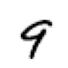

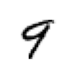

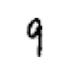

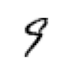

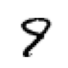

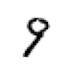

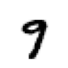

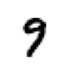

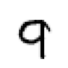

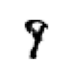

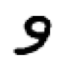

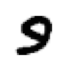

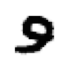

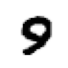

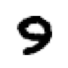

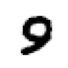

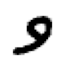

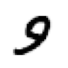

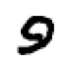

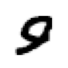

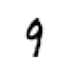

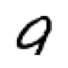

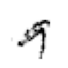

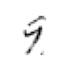

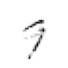

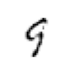

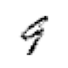

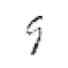

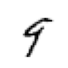

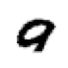

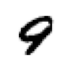

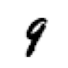

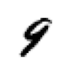

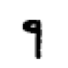

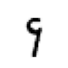

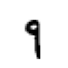

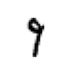

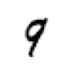

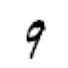

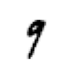

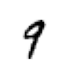

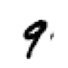

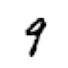

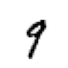

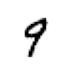

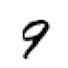

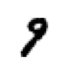

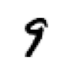

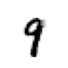

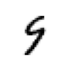

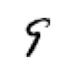

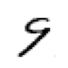

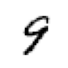

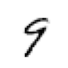

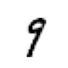

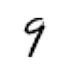

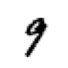

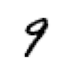

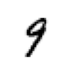

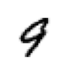

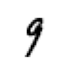

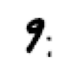

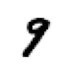

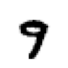

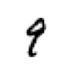

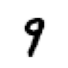

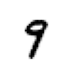

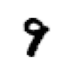

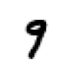

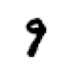

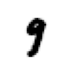

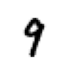

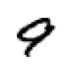

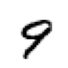

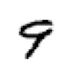

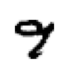

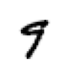

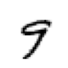

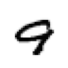

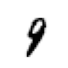

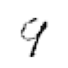

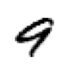

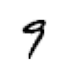

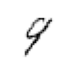

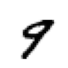

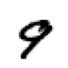

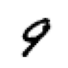

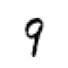

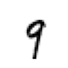

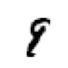

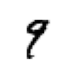

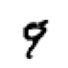

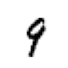

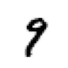

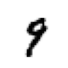

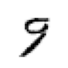

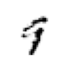

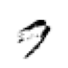

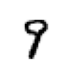

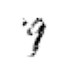

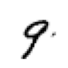

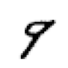

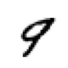

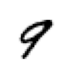

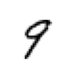

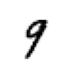

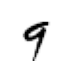

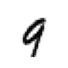

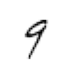

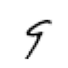

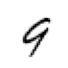

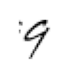

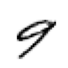

In [41]:
# before trying tensor and broadcasting, try loops
for i, one_9 in enumerate(valid_digit_tensors[9]):
    # show_image(one_9), show_image(train_digit_means[9])
    loss_tensor = L([])
    for d in DIGITS:
        loss_tensor.append(F.l1_loss(one_9, train_digit_means[d]))
        # print(F.l1_loss(one_9, train_digit_means[d]), F.mse_loss(one_9, train_digit_means[d]).sqrt())
    val, idx = min((val, idx) for (idx, val) in enumerate(loss_tensor))
    # print(f'{idx}', end=' ')
    if not idx == 9:
        show_image(valid_digit_tensors[9][i])

In [42]:
# before trying tensor and broadcasting, try loops
errors = 0
for i, one_9 in enumerate(valid_digit_tensors[9]):
    # show_image(one_9), show_image(train_digit_means[9])
    loss_tensor = L([])
    for d in DIGITS:
        loss_tensor.append(F.l1_loss(one_9, train_digit_means[d]))
        # print(F.l1_loss(one_9, train_digit_means[d]), F.mse_loss(one_9, train_digit_means[d]).sqrt())
    val, idx = min((val, idx) for (idx, val) in enumerate(loss_tensor))
    # print(f'{idx}', end=' ')
    if not idx == 9:
        # show_image(valid_digit_tensors[9][i])
        errors = errors + 1

print(f'Accuracy: {1 - errors/len(valid_digit_tensors[9])}')

Accuracy: 0.77601585728444


In [ ]:
# may have purposely put challenging images in testing folder
# try combining all images, then sampling 80/20 train/valid split

# next, get accuracy for all digits, and average accuracy

In [53]:
# before trying tensor and broadcasting, try loops
errors_total = 0
samples_total = 0
for d in DIGITS:
    errors = 0
    for i, img in enumerate(valid_digit_tensors[d]):
        loss_tensor = L([])
        for d1 in DIGITS:
            loss_tensor.append(F.l1_loss(img, train_digit_means[d1]))
        val, idx = min((val, idx) for (idx, val) in enumerate(loss_tensor))
        if not idx == d:
            errors = errors + 1
    errors_total = errors_total + errors
    print(f'Accuracy for digit {d}: {1 - (errors / len(valid_digit_tensors[d]))}')
    samples_total = samples_total + len(valid_digit_tensors[d])

print(f'Overall accuracy in {samples_total} samples: {1 - (errors_total / samples_total)}')

Accuracy for digit 0: 0.8153061224489796
Accuracy for digit 1: 0.9982378854625551
Accuracy for digit 2: 0.42344961240310075
Accuracy for digit 3: 0.6089108910891089
Accuracy for digit 4: 0.6680244399185336
Accuracy for digit 5: 0.32623318385650224
Accuracy for digit 6: 0.7870563674321504
Accuracy for digit 7: 0.7645914396887159
Accuracy for digit 8: 0.4425051334702259
Accuracy for digit 9: 0.77601585728444
Overall accuracy in 10000 samples: 0.6685


In [54]:
# that wasn't great - let's try with MSE
errors_total = 0
samples_total = 0
for d in DIGITS:
    errors = 0
    for i, img in enumerate(valid_digit_tensors[d]):
        loss_tensor = L([])
        for d1 in DIGITS:
            loss_tensor.append(F.mse_loss(img, train_digit_means[d1]))
        val, idx = min((val, idx) for (idx, val) in enumerate(loss_tensor))
        if not idx == d:
            errors = errors + 1
    errors_total = errors_total + errors
    print(f'Accuracy for digit {d}: {1 - (errors / len(valid_digit_tensors[d]))}')
    samples_total = samples_total + len(valid_digit_tensors[d])

print(f'Overall accuracy in {samples_total} samples: {1 - (errors_total / samples_total)}')
# much better!

Accuracy for digit 0: 0.8959183673469387
Accuracy for digit 1: 0.9621145374449339
Accuracy for digit 2: 0.7567829457364341
Accuracy for digit 3: 0.805940594059406
Accuracy for digit 4: 0.8258655804480652
Accuracy for digit 5: 0.6860986547085202
Accuracy for digit 6: 0.8632567849686847
Accuracy for digit 7: 0.8326848249027238
Accuracy for digit 8: 0.7371663244353183
Accuracy for digit 9: 0.8067393458870169
Overall accuracy in 10000 samples: 0.8203


In [ ]:
# now do this using tensors and broadcasting


In [55]:
# detour into arrays, tensors
l = [[1,2,3], [4,5,6]]
print(array(l))
print(tensor(l))
# tensor looks identical, with extra parentheses

[[1 2 3]
 [4 5 6]]
tensor([[1, 2, 3],
        [4, 5, 6]])


In [62]:
# indexing
print(tensor(l)[0,:]) # first row
print(tensor(l)[:,0]) # first col
print(tensor(l)[:1,:2]) # first 1 row, first 2 columns

tensor([1, 2, 3])
tensor([1, 4])
tensor([[1, 2]])


In [64]:
type(tensor(l)), tensor(l).type()

(torch.Tensor, 'torch.LongTensor')

In [ ]:
# take this loop and try broadcasting
'''for i, img in enumerate(valid_digit_tensors[d]):
    loss_tensor = L([])
    for d1 in DIGITS:
        loss_tensor.append(F.mse_loss(img, train_digit_means[d1]))
    val, idx = min((val, idx) for (idx, val) in enumerate(loss_tensor))
    if not idx == d:
        errors = errors + 1
'''

In [69]:
type(img), img.shape, type(train_digit_means), train_digit_means[0].shape

(torch.Tensor, torch.Size([28, 28]), list, torch.Size([28, 28]))

In [72]:
type(valid_digit_tensors), type(valid_digit_tensors[0]), valid_digit_tensors[0].shape

(list, torch.Tensor, torch.Size([980, 28, 28]))

In [73]:
# start with the innermost level, then move out
'''loss_tensor = L([])
for d1 in DIGITS:
    loss_tensor.append(F.mse_loss(img, train_digit_means[d1]))'''
F.mse_loss(img, train_digit_means[0])

tensor(0.0848)

In [74]:
F.mse_loss(img, train_digit_means)

AttributeError: 'list' object has no attribute 'size'

In [77]:
tdm_t = torch.stack(train_digit_means) # not jagged, so can stack
tdm_t.shape

torch.Size([10, 28, 28])

In [78]:
F.mse_loss(img, tdm_t)

<ipython-input-78-2d92442c8f2e>:1: UserWarning: Using a target size (torch.Size([10, 28, 28])) that is different to the input size (torch.Size([28, 28])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  F.mse_loss(img, tdm_t)


tensor(0.0789)

In [80]:
F.mse_loss(tdm_t, img)

<ipython-input-80-d1f21707c7c2>:1: UserWarning: Using a target size (torch.Size([28, 28])) that is different to the input size (torch.Size([10, 28, 28])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  F.mse_loss(tdm_t, img)


tensor(0.0789)

In [83]:
((tdm_t - img)**2).mean().sqrt()

tensor(0.2808)

In [79]:
F.mse_loss(torch.stack(img), tdm_t)

TypeError: stack(): argument 'tensors' (position 1) must be tuple of Tensors, not Tensor

In [ ]:
# two lessons (1) for broadcasting to work, first parameter should be the higher rank
# (2) F.mse_loss() does not apply broadcasting right, but direct formula works

In [ ]:
# to understand broadcasting, need to understand element-wise op first

In [ ]:
# given that we believe we have a good 'starting point',
# can we transform this starting point into a set of weights
# that can be used for initializing the actual DL?

In [105]:
# instead of using greyscale, can we convert into black/white 0/1
# thus sharpening the image
# 1. using cut-off 256/2
# 2. comparing adjacent pixels and see if darker or lighter, on average

In [ ]:
# 7 steps of GD:
'''initialize
predict
loss
gradient
step
repeat -> predict
stop'''

/Users/rnm/miniconda3/lib/python3.8/site-packages/fastbook/__init__.py:73: UserWarning: Not providing a value for linspace's steps is deprecated and will throw a runtime error in a future release. This warning will appear only once per process. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1607370249289/work/aten/src/ATen/native/RangeFactories.cpp:23.)
  x = torch.linspace(min,max)


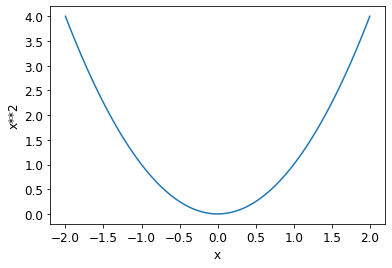

In [106]:
def f(x): return x**2
plot_function(f, 'x', 'x**2')

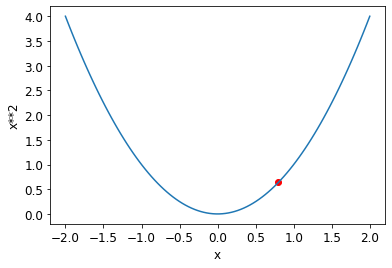

In [112]:
# add a point parameters: x, y, attrib
plot_function(f, 'x', 'x**2')
plt.scatter(0.8, f(0.8), color='red');

# need second line; must end 3rd line with a ";" - ugh

In [121]:
xt = tensor(3.).requires_grad_()
xt
# requires_grad is a special incantation that asks pytorch to augment
# the tensor with a data structure that remembers all the operations
# done on the tensor (is it *all* operations or only gradient-related?)
# *all*; this data-stru is *used* to calculate gradient
# _ at end says make the operation in-place

tensor(3., requires_grad=True)

In [122]:
yt = f(xt)
yt
# Pow -- power function
# Backward -- used for back propagation (== calculate gradient)
# 0 -- first op (?)

tensor(9., grad_fn=<PowBackward0>)

In [123]:
yt.backward()
xt.grad
# note: backward is called on yt, but grad is requested on xt
# internally xt, yt is part of same compound data structure attached to tensor xt

# yt.backward() can be called only once
# moves pointer such that it cannot be used any more
# i.e. does something, modified ds in a destructive way, so cannot be repeated

tensor(6.)

In [124]:
# can be extended to tensor of arbitrary shape
xt = tensor([1.,2.,3.], [4.,5.,6.]).requires_grad_()
print(xt)
yt = f(xt)
print(yt)
yt.backward()
print(xt.grad)
# RuntimeError: grad can be implicitly created only for scalar outputs

tensor([[1., 2., 3.],
        [4., 5., 6.]], requires_grad=True)
tensor([[ 1.,  4.,  9.],
        [16., 25., 36.]], grad_fn=<PowBackward0>)


RuntimeError: grad can be implicitly created only for scalar outputs

In [125]:
# can be extended to rank-1 tensor with any number of elements
xt = tensor([4.,5.,6.]).requires_grad_()
print(xt)
yt = f(xt)
print(yt)
yt.backward()
print(xt.grad)
# RuntimeError: grad can be implicitly created only for scalar outputs

tensor([4., 5., 6.], requires_grad=True)
tensor([16., 25., 36.], grad_fn=<PowBackward0>)


RuntimeError: grad can be implicitly created only for scalar outputs

In [127]:
# can be extended to rank-1 tensor with any number of elements -- no!
# f(x) must return a scalar
def f(x): return (x**2).sum()

xt = tensor([4.,5.,6.]).requires_grad_()
print(xt)
yt = f(xt)
print(yt)
yt.backward()
print(xt.grad)

tensor([4., 5., 6.], requires_grad=True)
tensor(77., grad_fn=<SumBackward0>)
tensor([ 8., 10., 12.])


In [128]:
# f(x) must return a scalar
# can be extended to tensor with any shape

def f(x): return (x**2).sum()

xt = tensor([3.,1.,2.],[4.,5.,6.]).requires_grad_()
print(xt)
yt = f(xt)
print(yt)
yt.backward()

print(xt.grad)

tensor([[3., 1., 2.],
        [4., 5., 6.]], requires_grad=True)
tensor(91., grad_fn=<SumBackward0>)
tensor([[ 6.,  2.,  4.],
        [ 8., 10., 12.]])


In [129]:
# step
# w -= gradient(w) * learning_rate

In [130]:
# Arthur Samuel technique: find set of parameters that can be modified
# iteratively and used to make our predictions improve incrementally

In [131]:
# applying to MNIST - output is dichotomous - hence need for a special loss function
# can't use accuracy -- gradient will be zero or near zero so may not converge

In [ ]:
torch.cat() # concatenate vertically (by first dim)
view(-1, vector) # flattens elements other than first dim into a vector
unsqueeze(1) # adds a dim
list(zip(x,y)) # create dset required as input to torch

In [132]:
# neat trick to unwrap tensor elements into python scalar
# to reveal full precision .item()

In [ ]:
# accuracy is not a good choice for loss
# is a step function with flat over most of x, a sudden vertical change at 0.5
# our model will not improve with zero gradient
# need a 'smooth' curve

In [133]:
# why we need a loss and a metric
# metric is the thing we really care about
# loss is a mathematical / computational implementation that closely
# tracks our metric and has a nicely behaved gradient

In [ ]:
# for regression problems, metric and loss can be MSE

In [134]:
# choice of batch size - as big as can fit into GPU memory

In [ ]:
# why mean, why not a median?
# once order established, median is not sensitive
# hence would have less desirable gradient property

In [137]:
# demo of mini-batch
coll = range(0,15)
dl = DataLoader(coll, batch_size=5, shuffle=True)
list(dl)
# DataLoader is a iterator - defined in torch, modified in fastai
# calling list() on a DataLoader performs comprehension - makes repeated calls and exhausts pipe

[tensor([ 8,  9,  5, 11,  4]),
 tensor([ 7, 13, 14,  2,  3]),
 tensor([ 6, 12, 10,  1,  0])]

In [138]:
L(dl)

(#3) [tensor([6, 1, 9, 4, 5]),tensor([14,  7,  8,  2, 10]),tensor([11,  3, 12, 13,  0])]

In [139]:
# batch size need not fit nicely as multiples of full ds
# also demo'ing how predictors and targets are handled together by torch ds
ds = L(enumerate(string.ascii_lowercase))
ds

(#26) [(0, 'a'),(1, 'b'),(2, 'c'),(3, 'd'),(4, 'e'),(5, 'f'),(6, 'g'),(7, 'h'),(8, 'i'),(9, 'j')...]

In [140]:
dl = DataLoader(ds, batch_size=6, shuffle=True)
L(dl)

(#5) [(tensor([19, 14,  0, 24, 20, 12]), ('t', 'o', 'a', 'y', 'u', 'm')),(tensor([23,  8,  9,  3, 16,  6]), ('x', 'i', 'j', 'd', 'q', 'g')),(tensor([ 4,  7,  1, 13,  2, 22]), ('e', 'h', 'b', 'n', 'c', 'w')),(tensor([ 5, 17, 18, 10, 11, 15]), ('f', 'r', 's', 'k', 'l', 'p')),(tensor([25, 21]), ('z', 'v'))]

In [ ]:
# algo
for x,y in ds:
    # is there a parameters init here? Yes!
    parameters = init_parm(...)
    pred = model(x)
    loss = loss_function(pred, y)
    loss.backward() # step is called on loss
    parameters -= parameters.grad * lr

In [ ]:
# first(dl) fastai function to grab first element / batch from a iterator

In [141]:
# GD vs SGD: GD works on whole ds; SGD works on mini-batch increments

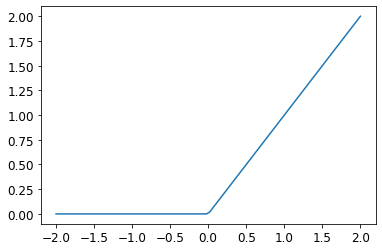

In [144]:
plot_function(F.relu)

/Users/rnm/miniconda3/lib/python3.8/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


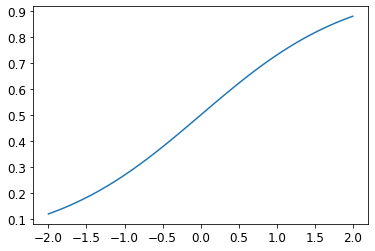

In [145]:
plot_function(F.sigmoid)

In [147]:
# to go from linear function to nn - go from one hidden layer to several
# need a activation function to be interspersed between layers
# this makes it non-linear
# Universal Approximation Theorem applies to these multilayered nn (not to single layer)
# these can theoretically solve any function to any desired level of accuracy

In [ ]:
# nn with more layers are more complex and unwiedly
# (more parameters; more degrees of freedom),
# hence more difficult to handle.
# Generally require smaller learning rate.

# First layer retains some semblance of incoming data
# but resemblance fades away fast as we move farther away

# taking a 768 vector and squishing into a 30 neuron vector
# is like developing 30 different models
# which are combined in next (activation) layer

# activations are also considered layers
# so a 2-linear layer nn with one activation in between
# is really a 3-layer nn

# inside the model it is all (floating point - full or half precision) numbers
# (1) parameters (these are learnt)
# (2) activations (these are computed)

In [ ]:
# rank 1,2,3: scalar, vector, matrix (some have 4,5 - 6+ ranks not seen in practice (?))

In [148]:
# choice of activation functions don't matter too much
# some get to answer faster, or may be a little more accurate
# but not by much
# reasonable choice leaky relu

In [149]:
# nn.Sequential is an example of function composition
# output of one function fed to next, and so on
# F.relu() is a method; nn.relu() is a class (why; how does it matter?)

In [150]:
# 4-line version, then to from-scratch version
# now use interpolated versions to look at other applications

In [ ]:
# ch5 image classification
# Path.BASE_PATH = path is only a little trick to stop displaying full path each time
# name_of_breek = re.findll(r'(.+)_\d+\.jpg', file_name)

In [152]:
# start by buiding datablock
# debug it with .summary
#! start building a model right away to help find anamolies in data
# visualize data using this model
# confusion matrix, good predictions, bad predictions, borderline preds
# Image Cleaner! - keep, discard, ...

In [153]:
# cross entropy loss (softmax) - multinomial version of sigmoid for binary target

In [ ]:
# softmax = exp(x) / exp(x).sum()

In [ ]:
# softmax has tendency to exxaggerate differences
# sometimes, better to identify top 2 candidates, then use sigmoid to see how close they are

In [155]:
# indexing expression - picking nth element in a list of lists based on a vector of indexes
# tensor[row, col] where row is a vector and col is a vector; returns 'row' elements

In [157]:
# corresponding to softmax activation, we use negative log likelihood as loss function
# pytorch assumes you use log_softmax, so nll_loss does not take log again

In [ ]:
# effective communication to decision makers

In [84]:
((tdm_t - img)**2).mean().sqrt()

tensor(0.2808)

In [85]:
((train_digit_means[0] - img)**2).mean().sqrt()

tensor(0.2912)

In [86]:
((torch.stack(train_digit_means) - img)**2).mean().sqrt()
# did not work - expecting a vector rank-1 tensor; instead getting a rank-0 scalar

tensor(0.2808)

In [89]:
((train_digit_means[0] - valid_digit_tensors[0])**2).shape

torch.Size([980, 28, 28])

In [94]:
# ah ha - it was the mean() that was messing up
t = ((torch.stack(train_digit_means) - img)**2).mean((-1, -2)).sqrt()
t.shape, t, min(t)

(torch.Size([10]),
 tensor([0.2912, 0.3339, 0.3022, 0.3086, 0.2240, 0.2752, 0.2818, 0.2671, 0.2772, 0.2284]),
 tensor(0.2240))

<AxesSubplot:>

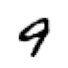

In [95]:
# so algo thinks this is a 4 or a 9 (equal loss)
show_image(img)

torch.Size([10]) tensor([0.0848, 0.1115, 0.0913, 0.0953, 0.0502, 0.0758, 0.0794, 0.0714, 0.0768, 0.0522]) tensor(0.0502)


<AxesSubplot:>

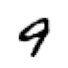

In [97]:
# check if different when MSE (not RMSE) is used
t = ((torch.stack(train_digit_means) - img)**2).mean((-1, -2))
print(t.shape, t, min(t))
show_image(img)
# nope - identical
# is there a way to force higher precision?

In [103]:
type(t), type(t[0]), type(t[0])

(torch.Tensor, torch.Tensor, torch.Tensor)

In [104]:
dir(t)
# how do I find type of element in tensor - float32, float64, half-precision?

['T',
 '__abs__',
 '__add__',
 '__and__',
 '__array__',
 '__array_eq__',
 '__array_priority__',
 '__array_wrap__',
 '__bool__',
 '__class__',
 '__complex__',
 '__contains__',
 '__deepcopy__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__div__',
 '__doc__',
 '__eq__',
 '__float__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__iand__',
 '__idiv__',
 '__ifloordiv__',
 '__ilshift__',
 '__imul__',
 '__index__',
 '__init__',
 '__init_subclass__',
 '__int__',
 '__invert__',
 '__ior__',
 '__ipow__',
 '__irshift__',
 '__isub__',
 '__iter__',
 '__itruediv__',
 '__ixor__',
 '__le__',
 '__len__',
 '__long__',
 '__lshift__',
 '__lt__',
 '__matmul__',
 '__mod__',
 '__module__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__nonzero__',
 '__or__',
 '__pow__',
 '__radd__',
 '__rdiv__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__reversed__',
 '__rfloordiv__',
 '__rmul__',
 '__rpow__',
 '__rshift__',
 

In [76]:
# both losses are lowest for 9
# next, sum losses for all valid ('testing') samples
# first try 'broadcast' for all labeled 9s
valid_digit_paths = [(path/'testing'/digit).ls().sorted()
                        for digit in digits]

valid_digit_tensors = [torch.stack(
    [tensor(Image.open(img)).float()/255
        for img in valid_digit_paths[d]])
            for d in DIGITS]

for d in DIGITS:
    print(d, valid_digit_tensors[d].shape)

one_9 = valid_digit_tensors[9][100]
loss_tensor = L([])
for d in DIGITS:
    loss_tensor.append(F.l1_loss(one_9, train_digit_means[d]))

for d in DIGITS:
    print(F.l1_loss(one_9, train_digit_means[d]), F.mse_loss(one_9, train_digit_means[d]).sqrt())

0 torch.Size([980, 28, 28])
1 torch.Size([1135, 28, 28])
2 torch.Size([1032, 28, 28])
3 torch.Size([1010, 28, 28])
4 torch.Size([982, 28, 28])
5 torch.Size([892, 28, 28])
6 torch.Size([958, 28, 28])
7 torch.Size([1028, 28, 28])
8 torch.Size([974, 28, 28])
9 torch.Size([1009, 28, 28])
tensor(0.1950) tensor(0.3318)
tensor(0.1413) tensor(0.3026)
tensor(0.1647) tensor(0.2858)
tensor(0.1658) tensor(0.2950)
tensor(0.1218) tensor(0.2314)
tensor(0.1591) tensor(0.2816)
tensor(0.1535) tensor(0.2843)
tensor(0.1317) tensor(0.2582)
tensor(0.1487) tensor(0.2676)
tensor(0.1096) tensor(0.2135)


In [79]:
# both losses are lowest for 9
# next, sum losses for all valid ('testing') samples
# first try 'broadcast' for all labeled 9s
valid_digit_paths = [(path/'testing'/str(digit)).ls().sorted()
                        for digit in DIGITS]

valid_digit_tensors = [torch.stack(
    [tensor(Image.open(img)).float()/255
        for img in valid_digit_paths[d]])
            for d in DIGITS]

for d in DIGITS:
    print(d, valid_digit_tensors[d].shape)

one_9 = valid_digit_tensors[9][100]
for d in DIGITS:
    print(F.l1_loss(one_9, train_digit_means[d]), F.mse_loss(one_9, train_digit_means[d]).sqrt())

0 torch.Size([980, 28, 28])
1 torch.Size([1135, 28, 28])
2 torch.Size([1032, 28, 28])
3 torch.Size([1010, 28, 28])
4 torch.Size([982, 28, 28])
5 torch.Size([892, 28, 28])
6 torch.Size([958, 28, 28])
7 torch.Size([1028, 28, 28])
8 torch.Size([974, 28, 28])
9 torch.Size([1009, 28, 28])
tensor(0.1950) tensor(0.3318)
tensor(0.1413) tensor(0.3026)
tensor(0.1647) tensor(0.2858)
tensor(0.1658) tensor(0.2950)
tensor(0.1218) tensor(0.2314)
tensor(0.1591) tensor(0.2816)
tensor(0.1535) tensor(0.2843)
tensor(0.1317) tensor(0.2582)
tensor(0.1487) tensor(0.2676)
tensor(0.1096) tensor(0.2135)


In [81]:
# need to convert into a tensor of (True, False)
def predict_right(one_9):
    loss_tensor = L([])
    for d in DIGITS:
        loss_tensor.append(F.l1_loss(one_9, train_digit_means[d]))
    val, idx = min((val, idx) for (idx, val) in enumerate(loss_tensor))
    return (val, idx)

predict_right(one_9)

(tensor(0.1096), 9)

In [84]:
predict_right(valid_digit_tensors[3])

<ipython-input-81-4aaf78aaada0>:5: UserWarning: Using a target size (torch.Size([28, 28])) that is different to the input size (torch.Size([1010, 28, 28])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss_tensor.append(F.l1_loss(one_9, train_digit_means[d]))


(tensor(0.1296), 3)

In [85]:
# above function works, but still give raw loss - need to get to metric T/F

In [86]:
loss = F.l1_loss(valid_digit_tensors[9], train_digit_means[9])
loss                                     

<ipython-input-86-72070be09e2a>:1: UserWarning: Using a target size (torch.Size([28, 28])) that is different to the input size (torch.Size([1009, 28, 28])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.l1_loss(valid_digit_tensors[9], train_digit_means[9])


tensor(0.1118)

In [96]:
# for each obs, find best match
# if best match is same as actual lable, return True
def is_pred_right(one_9, label):
    loss = tensor([F.l1_loss(one_9, train_digit_means[d]) for d in DIGITS])
    print(loss.shape)
    val, idx = min((val, idx) for (idx, val) in enumerate(loss))
    # print(idx.shape)
    return idx == label

is_pred_right(one_9, 9)

torch.Size([10])


True

In [91]:
x = is_pred_right(valid_digit_tensors[9], tensor([9]))
x

<ipython-input-87-b67aa8848f27>:4: UserWarning: Using a target size (torch.Size([28, 28])) that is different to the input size (torch.Size([1009, 28, 28])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = [F.l1_loss(one_9, train_digit_means[d]) for d in DIGITS]


tensor([True])

In [93]:
valid_digit_tensors[9].shape, tensor([9]).shape, x.shape

(torch.Size([1009, 28, 28]), torch.Size([1]), torch.Size([1]))

In [98]:
x = torch.stack(valid_digit_tensors)

RuntimeError: stack expects each tensor to be equal size, but got [980, 28, 28] at entry 0 and [1135, 28, 28] at entry 1

In [99]:
def mnist_loss(a, b):
    return F.l1_loss(a,b)

mnist_loss(one_9, train_digit_means[9])

tensor(0.1096)

In [102]:
x = mnist_loss(valid_digit_tensors[9], train_digit_means[9])
x.shape

<ipython-input-99-bb8473ee0476>:2: UserWarning: Using a target size (torch.Size([28, 28])) that is different to the input size (torch.Size([1009, 28, 28])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(a,b)


torch.Size([])

In [105]:
def mnist_loss2(a, b):
    return (a - b).abs().mean((-1, -2))

x = mnist_loss2(one_9, train_digit_means[9])

In [106]:
x.shape

torch.Size([])

In [107]:
x = mnist_loss2(valid_digit_tensors[9], train_digit_means[9])
x.shape

torch.Size([1009])

In [108]:
# weird F.l1_loss does not return correct tensor shape,
# but explicit MAD code does

In [113]:
def is_9(x):
    loss = tensor([mnist_loss2(x, train_digit_means[d]) for d in DIGITS])
    print(loss.shape)
    val, idx = min((val, idx) for (idx, val) in enumerate(loss))
    return (val, idx)

x = is_9(one_9)
print(x)

torch.Size([10])
(tensor(0.1096), 9)


In [114]:
x = is_9(valid_digit_tensors[9])
print(x)

ValueError: only one element tensors can be converted to Python scalars

In [115]:
%debug

> /Users/rnm/miniconda3/lib/python3.8/site-packages/fastai/torch_core.py(127)tensor()
    125     # if isinstance(x, (tuple,list)) and len(x)==0: return tensor(0)
    126     res = (x if isinstance(x, Tensor)
--> 127            else torch.tensor(x, **kwargs) if isinstance(x, (tuple,list))
    128            else _array2tensor(x) if isinstance(x, ndarray)
    129            else as_tensor(x.values, **kwargs) if isinstance(x, (pd.Series, pd.DataFrame))

ipdb> d
*** Newest frame
ipdb> print(d)
*** NameError: name 'd' is not defined
ipdb> x
[tensor([0.1971, 0.1850, 0.1914,  ..., 0.1723, 0.1807, 0.1680]), tensor([0.0989, 0.1053, 0.1197,  ..., 0.1426, 0.1264, 0.1588]), tensor([0.1550, 0.1499, 0.1655,  ..., 0.1734, 0.1480, 0.1765]), tensor([0.1352, 0.1383, 0.1395,  ..., 0.1792, 0.1427, 0.1736]), tensor([0.1291, 0.1094, 0.1135,  ..., 0.1175, 0.1110, 0.1172]), tensor([0.1398, 0.1305, 0.1345,  ..., 0.1502, 0.1430, 0.1536]), tensor([0.1525, 0.1388, 0.1421,  ..., 0.1589, 0.1415, 0.1522]), tensor([

In [ ]:
# start repro book Chapter 4: page 160

In [4]:
x_t = tensor([3.]).requires_grad_()
x_t

tensor([3.], requires_grad=True)

In [3]:
def f(x):
    return x**2

In [5]:
y_t = f(x_t)
y_t, y_t.shape

(tensor([9.], grad_fn=<PowBackward0>), torch.Size([1]))

In [6]:
y_t.backward()
print(x_t.grad)

tensor([6.])


In [7]:
x_t.grad = None

In [8]:
x_t, y_t

(tensor([3.], requires_grad=True), tensor([9.], grad_fn=<PowBackward0>))

In [9]:
# try with a list of rank-1 tensors

In [10]:
x_t = tensor([3., 4., 2.]).requires_grad_()
x_t

tensor([3., 4., 2.], requires_grad=True)

In [11]:
# function must return a scalar
def f(x): return (x**2).sum()

y_t = f(x_t)
y_t, y_t.shape

(tensor(29., grad_fn=<SumBackward0>), torch.Size([]))

In [12]:
# why is y_t.shape returning torch.Size([]) (not ([1]) like in previous step?)
# what does torch.Size([]) mean?

In [13]:
y_t.backward()
print(x_t.grad)

tensor([6., 8., 4.])


In [128]:
# backward is applied on y, but grad is checked on x

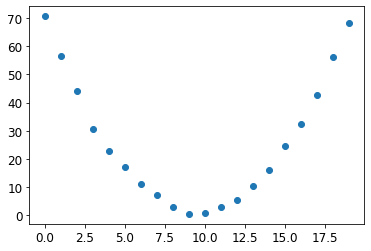

In [14]:
# now try to reproduce quadratic example - parameters a,b,c
xt = torch.arange(20)
yt = 0.75 * (xt - 9.5) ** 2 + 1 + torch.randn(20)
plt.scatter(xt, yt)

In [15]:
# here is the critical indirection part - introducing weights and bias (parameters)
# we modify these; the original xt and yt remain (sample data, labels)
# goal then becomes guessing a function, making predictions with that function, checking against label,
# making adjustments to parameters, repeat until goal met

# here we start with a simplyfying assumption
# we know it is a quadratic; so goal is to guess (a,b,c) which define the quadratic
def f(x, params):
    a, b, c = params # split tuple
    return a * (x**2) + b * (x) + c

In [24]:
# we also need a way to check how close we are to label - loss function
# singe target is continuous, we choose mse
def loss_f(preds, targets):
    return ((preds - targets) ** 2).mean()

In [61]:
# start with a initial guess for the indirection params
# this is the var that changes from iteration to iteration - hence must have gradient that we track
params = torch.randn(3).requires_grad_()

In [18]:
def show_preds(xt, yt, preds, ax=None):
    if ax is None:
        ax = plt.subplots()[1]
        ax.scatter(xt, yt) # true function
        ax.scatter(xt, to_np(preds), color='red')
        ax.set_ylim(-300, 100)

Initial params: tensor([ 0.6863, -0.3278,  0.7950], requires_grad=True)


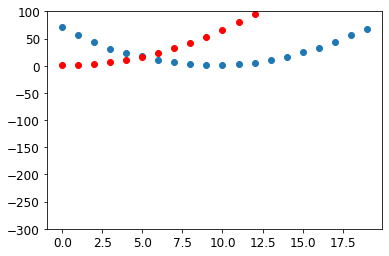

In [37]:
# lay out first cycle
print(f'Initial params: {params}')
preds = f(xt, params)
show_preds(xt, yt, preds)

In [38]:
loss = loss_f(preds, yt)
print(loss)

tensor(8588.4072, grad_fn=<MeanBackward0>)


In [39]:
# appears one can make repeated calls on loss_f and get back same answer
# it is yt.backward() and/or params.grad that must be called only once

In [40]:
((preds - yt) ** 2).mean()

tensor(8588.4072, grad_fn=<MeanBackward0>)

In [41]:
loss_f(preds,yt)

tensor(8588.4072, grad_fn=<MeanBackward0>)

In [42]:
loss.backward()

In [43]:
# loss.backward() # if called second time RuntimeError: Trying to backward through the graph a second time
# must go back and repeat from params = torch.randn(3).requires_grad_()

In [44]:
lr = 1e-5

In [45]:
params.data = params.grad.data * lr
params.grad = None

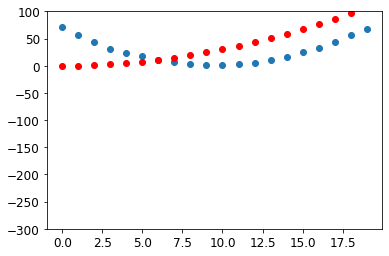

In [46]:
# make new preds and check
preds = f(xt, params)
show_preds(xt, yt, preds)

In [47]:
# now set up func to repeat
def apply_step(params, prn=True):
    preds = f(xt, params)
    loss = loss_f(preds, yt)
    loss.backward()
    params.data -= params.grad.data * lr
    params.grad = None
    if prn:
        print(loss.item())
    return preds

In [63]:
for i in range(20):
    apply_step(params)

1281.104736328125
767.0296020507812
669.7479858398438
651.3367919921875
647.8499145507812
647.1875610351562
647.0594482421875
647.032470703125
647.0245971679688
647.0203857421875
647.0169067382812
647.0136108398438
647.01025390625
647.0069580078125
647.0035400390625
647.0001831054688
646.996826171875
646.9935302734375
646.9900512695312
646.98681640625


In [62]:
def plot_4_cycles(params):
    _, axs = plt.subplots(1, 4, figsize=(12, 3))
    for ax in axs:
        show_preds(xt, yt, apply_step(params, prn=False), ax)
    plt.tight_layout()

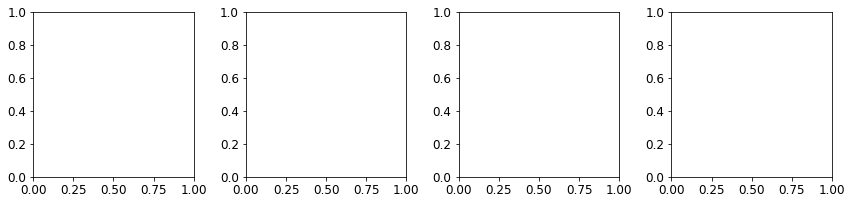

In [60]:
plot_4_cycles(params)

In [64]:
# plots not working - will move on for now

In [69]:
def show_preds(preds, ax=None):
    if ax is None:
        ax = plt.subplots()[1]
        ax.scatter(xt, yt) # true function
        ax.scatter(xt, to_np(preds), color='red')
        # ax.set_ylim(-300, 100)

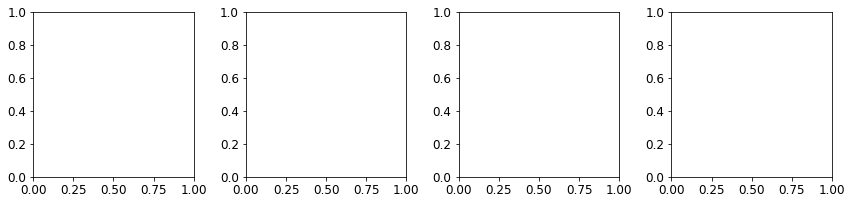

In [70]:
_,axs = plt.subplots(1,4,figsize=(12,3))
for ax in axs: show_preds(apply_step(params, False), ax)
plt.tight_layout()

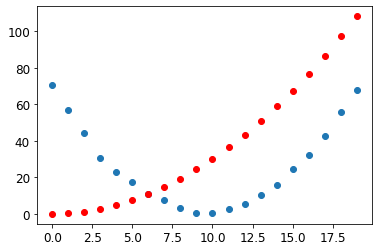

In [71]:
show_preds(preds)

In [72]:
# now set up func to repeat
def apply_step(params, prn=True):
    preds = f(xt, params)
    show_preds(preds)
    loss = loss_f(preds, yt)
    loss.backward()
    params.data -= params.grad.data * lr
    params.grad = None
    if prn:
        print(loss.item())
    return preds

932.3419189453125
711.3892822265625
669.5747680664062
661.6585083007812
660.1569213867188


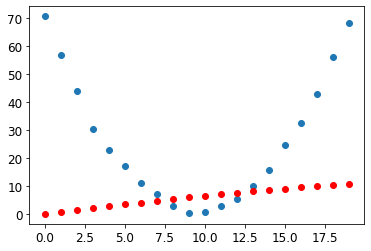

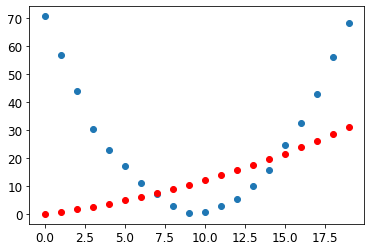

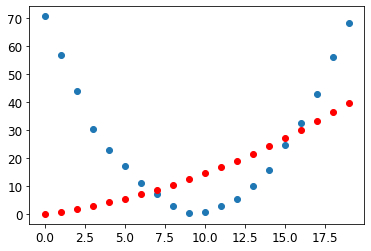

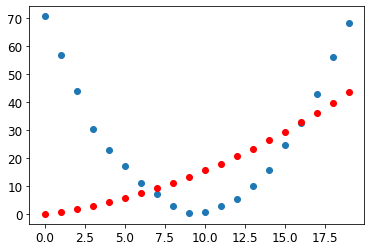

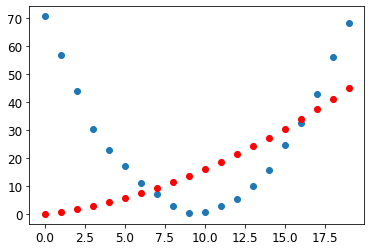

In [75]:
params = torch.randn(3).requires_grad_()
for i in range(5):
    apply_step(params)